# pressure

this notebook annotates high and low pressure centers. the algorithm:

1) find the max pressure (or height)
2) annotate it with an H
3) mask out a 300km circle around it
4) select the maximum value again
5) if the maximum value is almost exactly 300km from the previous value, discard it and expand the circle a further 300km
6) if the maximum is a new local max, mark it with an H
7) terminate after n=10 ish
8) repeat for low pressure centers, marking them with L's

In [ ]:
from herbie import Herbie
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "heavy"
from toolbox import EasyMap, pc
import cartopy.crs as ccrs
import cartopy.feature as feature
import pandas as pd

from matplotlib.patches import Rectangle
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pytz
import os, shutil
import json

import warnings

# supress because removal of old datafiles is handled outside herbie
warnings.filterwarnings("ignore")

from bmwflib import (
    clear_directory,
    get_var,
    plot_cities,
    make_figure,
    make_title,
)

%load_ext jupyter_black

In [149]:
now = pd.Timestamp.utcnow().floor("6h").tz_localize(None)

In [162]:
ds = get_var(now, "gdps", 3, "PRMSL", "MSL_0")
ds["prmsl"] /= 100

✅ Found ┊ model=gdps ┊ product=15km/grib2/lat_lon ┊ 2025-Jun-15 12:00 UTC F03 ┊ GRIB2 @ msc ┊ IDX @ None


TypeError: Input z must be 2D, not 1D

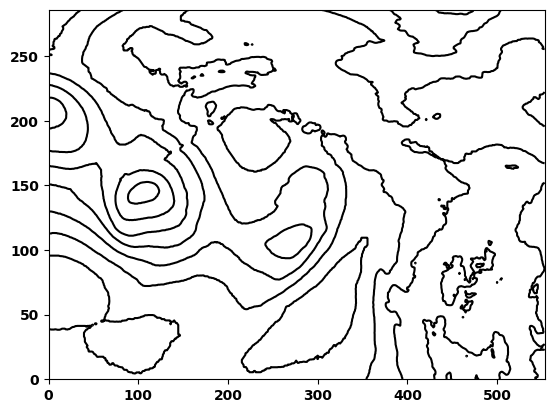

In [216]:
pres = np.array(ds.prmsl)
the_max = np.where(pres == pres.max())
xmax = the_max[0][0]
ymax = the_max[1][0]

plt.contour(pres, colors="k")

mn = ax.contourf(
    pres[pres < 998],
    colors="blue",
    transform=pc,
)

plt.text(xmax, ymax, "H", size=20, ha="center", va="center")

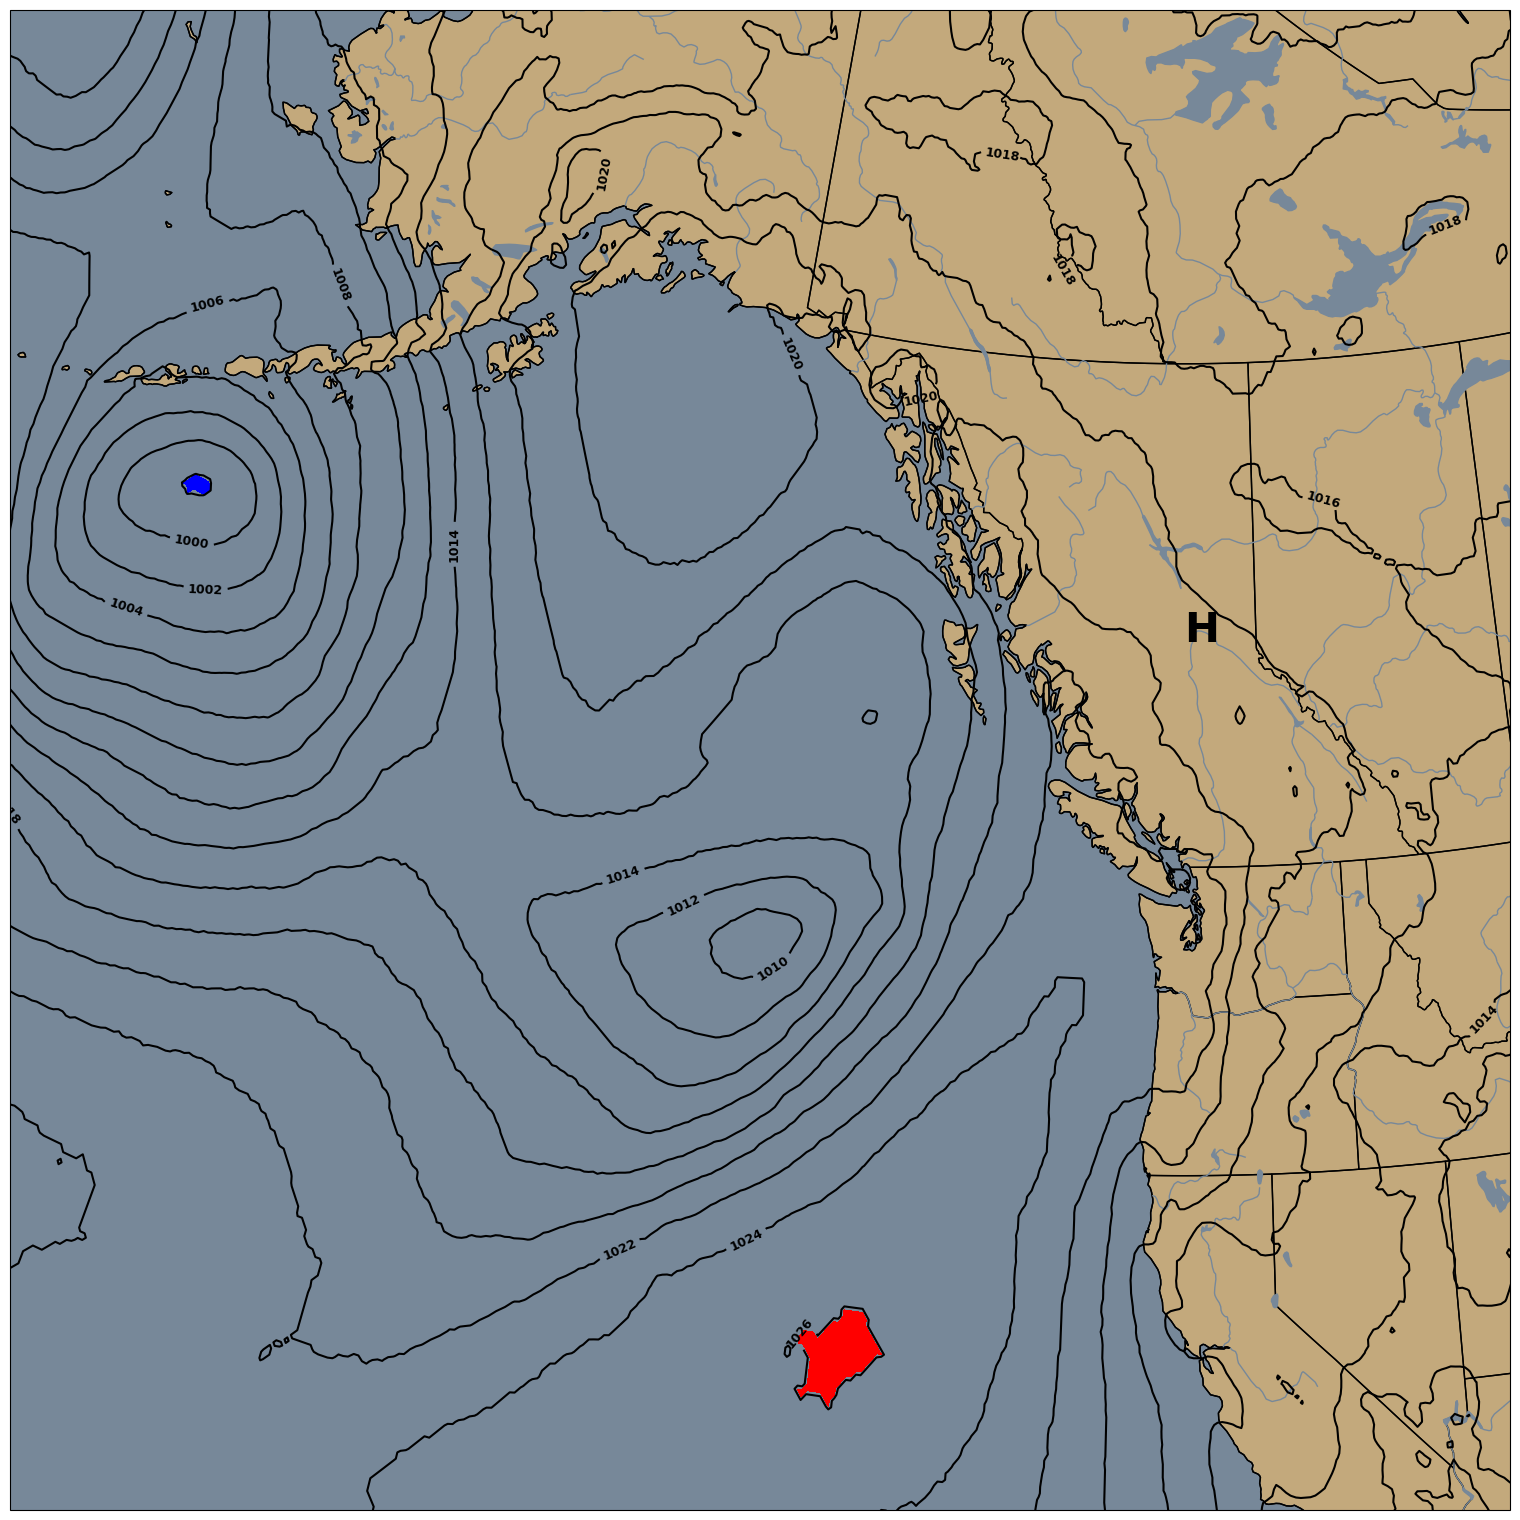

In [184]:
pres = np.array(ds.prmsl)
the_max = np.where(pres == pres.max())


fig, ax = make_figure(extent="MWF")
# plot height contours
ht = ax.contour(
    ds.longitude,
    ds.latitude,
    pres,
    colors="k",
    transform=pc,
    levels=range(900, 1100, 2),
)
ax.clabel(ht, inline=True, fontsize=9)

mx = ax.contourf(
    ds.longitude,
    ds.latitude,
    ds.prmsl.where(ds.prmsl > 1026),
    colors="red",
    transform=pc,
)

mn = ax.contourf(
    ds.longitude,
    ds.latitude,
    ds.prmsl.where(ds.prmsl < 998),
    colors="blue",
    transform=pc,
)


ax.text(
    ds.longitude[the_max[1][0]],
    ds.latitude[the_max[0][0]],
    "H",
    size=30,
)

fig.show()